## Data import and Cleaning

In [33]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import Bio
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import requests
from io import StringIO
from Bio import SeqIO

epitopes = pd.read_csv(r'/Users/tariq/Documents/capstone/data/epitope_table_export_1740279588.csv')
assays = pd.read_csv(r'/Users/tariq/Documents/capstone/data/tcell_table_export_1740279970.csv')

def fetch_full_sequence(url):
    if pd.notna(url):  # Check if the URL is not NaN
        url = f'{url}.fasta'
        try:
            response = requests.get(url)
            if response.status_code == 200:
                fasta_io = StringIO(response.text)
                records = list(SeqIO.parse(fasta_io, "fasta"))
                if records:  # Check if there are any records
                    return str(records[0].seq)
                else:
                    print("No records found in the FASTA file.")
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
    return None

#epitopes['Full Sequence'] = epitopes['Epitope - Molecule Parent IRI'].apply(fetch_full_sequence)
epitopes = pd.read_csv(r'/Users/tariq/Documents/capstone/data/epitope_full_seq.csv')

# make all the column names snake case
epitopes.columns = epitopes.columns.str.lower()
assays.columns = assays.columns.str.lower()

# remove spaces from column names
epitopes.columns = epitopes.columns.str.replace(' ', '')
epitopes.columns = epitopes.columns.str.replace('-', ' ')
epitopes.columns = epitopes.columns.str.replace(' ', '_')

assays.columns = assays.columns.str.replace(' ', '')
assays.columns = assays.columns.str.replace('-', ' ')
assays.columns = assays.columns.str.replace(' ', '_')

epitopes = epitopes.filter(['epitope_name', 'fullsequence'])
assays = assays.filter(['epitope_name', 'epitope_moluculeparent', 'host_name', 'host_mhcpresent', 'assay_method','assay_responsemeasured', 'assay_qualitativemeasurement', 'mhcrestriction_name', 'mhcrestriction_class', 'assayantigen_name'])

# map mhc name and class from the assays dataframe to a new column in the epitopes dataframe based on epitope_name
mhc = assays.filter(['epitope_name', 'mhcrestriction_name', 'mhcrestriction_class'])
mhc = mhc.drop_duplicates(subset=['epitope_name'])
epitopes = epitopes.merge(mhc, on='epitope_name', how='left')

/var/folders/5j/4p7c5_1x2fg18bk0nf74_hg40000gn/T/ipykernel_26117/2635103461.py:15: DtypeWarning: Columns (13,14,45,46,47,48,49,54,55,56,57,60,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,105,106,107,108,109,110,111,112,113,115,120,123,128,132,134,135,141,142,143,144,145,149,152) have mixed types. Specify dtype option on import or set low_memory=False.
  assays = pd.read_csv(r'/Users/tariq/Documents/capstone/data/tcell_table_export_1740279970.csv')


In [34]:
epitopes.head()

,epitope_name,fullsequence,mhcrestriction_name,mhcrestriction_class
0,AAGIGILTV,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A2,I
1,AAGIGILTVI,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A*02:01,I
2,ACDPHSGHFV,NaN,HLA-A2,I
3,ADLVGFLLLK,MSLEQRSLHCKPEEALEAQQEALGLVCVQAATSSSSPLVLGTLEEV...,HLA-A*11:01,I
4,ADVEFCLSL,MLLAVLYCLLWSFQTSAGHFPRACVSSKNLMEKECCPPWSGDRSPC...,HLA-B*44:03,I


In [35]:
assays.head()

,epitope_name,host_name,host_mhcpresent,assay_method,assay_responsemeasured,assay_qualitativemeasurement,mhcrestriction_name,mhcrestriction_class,assayantigen_name
0,APIWPYEILY,Homo sapiens (human),NaN,ELISPOT,IFNg release,Positive,HLA-B*35:01,I,APIWPYEILY
1,LIYDSSLCDL,Homo sapiens,NaN,ELISPOT,IFNg release,Positive,HLA-A2,I,LIYDSSLCDL
2,DRAHYNIVTFCCKCD,Homo sapiens (human),HLA-DR15,ELISPOT,IFNg release,Positive,HLA-DR15,II,DRAHYNIVTFCCKCD
3,DRAHYNIVTFCCKCD,Homo sapiens (human),HLA-DR15,ELISPOT,IL-5 release,Positive,HLA-DR15,II,DRAHYNIVTFCCKCD
4,MHGDTPTLHEYM,Homo sapiens (human),HLA-DR15;HLA-DR4,ELISPOT,IL-5 release,Positive,HLA class II,II,MHGDTPTLHEYM


## Feature Engineering

In [36]:
epitopes['epitope_length'] = epitopes['epitope_name'].str.len()

In [37]:
# Function to count amino acids in a peptide
def count_amino_acids(peptide):
    try:
        # Create a ProteinAnalysis object for the peptide
        analyzer = ProteinAnalysis(peptide)
        # Get amino acid counts and normalize to frequencies
        aa_count = analyzer.count_amino_acids()
        total_aa = sum(aa_count.values())
        aa_freq = {aa: count for aa, count in aa_count.items()}
        # Add the peptide itself to the results
        aa_freq['peptide'] = peptide
        return aa_freq
    except Exception as e:
        # Handle invalid peptides (e.g., with non-standard amino acids)
        result = {aa: 0 for aa in 'ACDEFGHIKLMNPQRSTVWY'}
        result['peptide'] = peptide
        return result

# Create analyzer function that will be used in the next cell
def analyzer(peptide):
    return count_amino_acids(peptide)

# Use both epitope name and peptide sequence in the DataFrame
epitope_composition_df = epitopes.apply(lambda row: count_amino_acids(row['epitope_name']), axis=1).apply(pd.Series)

In [38]:
epitope_composition_df.head()

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,peptide
0,2,0,0,0,0,2,0,2,0,1,...,0,0,0,0,0,1,1,0,0,AAGIGILTV
1,2,0,0,0,0,2,0,3,0,1,...,0,0,0,0,0,1,1,0,0,AAGIGILTVI
2,1,1,1,0,1,1,2,0,0,0,...,0,1,0,0,1,0,1,0,0,ACDPHSGHFV
3,1,0,1,0,1,1,0,0,1,4,...,0,0,0,0,0,0,1,0,0,ADLVGFLLLK
4,1,1,1,1,1,0,0,0,0,2,...,0,0,0,0,1,0,1,0,0,ADVEFCLSL


In [39]:
# Example DataFrame with a 'peptide' column
df = pd.DataFrame({
    'peptide': ['ACDEFGHIK', 'LMNPQRSTV', 'WYFP']
})

# Kyte-Doolittle hydrophobicity scale
kyte_doolittle = {
    'I': 4.5, 'V': 4.2, 'L': 3.8, 'F': 2.8, 'C': 2.5,
    'M': 1.9, 'A': 1.8, 'G': -0.4, 'T': -0.7, 'S': -0.8,
    'W': -0.9, 'Y': -1.3, 'P': -1.6, 'H': -3.2, 'E': -3.5,
    'Q': -3.5, 'D': -3.5, 'N': -3.5, 'K': -3.9, 'R': -4.5
}

def compute_avg_hydrophobicity(peptide):
    # Get hydrophobicity scores for each amino acid; default to 0 if missing
    scores = [kyte_doolittle.get(aa, 0) for aa in peptide]
    return sum(scores) / len(scores) if scores else 0

# Apply the function to the 'peptide' column to create a new column 'avg_hydro'
epitopes['epitope_avg_hydro'] = epitopes['epitope_name'].apply(compute_avg_hydrophobicity)
# Import the molecular_weight function from Bio.SeqUtils


def calculate_molecular_weight(peptide):
    """Calculate the molecular weight of a peptide sequence using Biopython."""
    try:
        # ProteinAnalysis only works with standard amino acids
        protein = ProteinAnalysis(peptide)
        return protein.molecular_weight()
    except Exception as e:
        # Handle peptides with non-standard amino acids
        return None

# Apply the function to calculate molecular weight for each epitope
epitopes['molecular_weight'] = epitopes['epitope_name'].apply(calculate_molecular_weight)
def calculate_aromaticity(peptide):
    """Calculate the aromaticity of a peptide sequence using Biopython."""
    try:
        # ProteinAnalysis only works with standard amino acids
        protein = ProteinAnalysis(peptide)
        return protein.aromaticity()
    except Exception as e:
        # Handle peptides with non-standard amino acids
        return None

# Apply the function to calculate molecular weight for each epitope
epitopes['aromaticity'] = epitopes['epitope_name'].apply(calculate_aromaticity)
def calculate_isoelectric_point(peptide):
    """Calculate the isoelectric point of a peptide sequence using Biopython."""
    try:
        # ProteinAnalysis only works with standard amino acids
        protein = ProteinAnalysis(peptide)
        return protein.isoelectric_point()
    except Exception as e:
        # Handle peptides with non-standard amino acids
        return None

# Apply the function to calculate molecular weight for each epitope
epitopes['isoelectric_point'] = epitopes['epitope_name'].apply(calculate_isoelectric_point)
def calculate_instability(peptide):
    """Calculate the instability of a peptide sequence using Biopython."""
    try:
        # ProteinAnalysis only works with standard amino acids
        protein = ProteinAnalysis(peptide)
        return protein.instability_index()
    except Exception as e:
        # Handle peptides with non-standard amino acids
        return None

# Apply the function to calculate molecular weight for each epitope
epitopes['instability'] = epitopes['epitope_name'].apply(calculate_instability)
def calculate_charge_at_pH7(peptide):
    """Calculate the charge of a peptide sequence at pH 7 using Biopython."""
    try:
        # ProteinAnalysis only works with standard amino acids
        protein = ProteinAnalysis(peptide)
        return protein.charge_at_pH(7)
    except Exception as e:
        # Handle peptides with non-standard amino acids
        return None

# Apply the function to calculate molecular weight for each epitope
epitopes['charge_at_pH7'] = epitopes['epitope_name'].apply(calculate_charge_at_pH7)

In [40]:
epitopes.head()

,epitope_name,fullsequence,mhcrestriction_name,mhcrestriction_class,epitope_length,epitope_avg_hydro,molecular_weight,aromaticity,isoelectric_point,instability,charge_at_pH7
0,AAGIGILTV,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A2,I,9,2.122222,813.9814,0.000000,5.570017,11.422222,-0.204125
1,AAGIGILTVI,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A*02:01,I,10,2.360000,927.1390,0.000000,5.570017,11.280000,-0.204125
2,ACDPHSGHFV,NaN,HLA-A2,I,10,-0.140000,1069.1507,0.100000,5.972266,61.830000,-1.038557
3,ADLVGFLLLK,MSLEQRSLHCKPEEALEAQQEALGLVCVQAATSSSSPLVLGTLEEV...,HLA-A*11:01,I,10,1.620000,1088.3394,0.100000,5.880358,-16.470000,-0.204004
4,ADVEFCLSL,MLLAVLYCLLWSFQTSAGHFPRACVSSKNLMEKECCPPWSGDRSPC...,HLA-B*44:03,I,9,1.233333,996.1348,0.111111,4.050028,20.855556,-2.210095


## Generation of Negative Samples

In [41]:
def generate_negatives(row):
    epitope = row["epitope_name"]
    full_seq = row["fullsequence"]
    mhc = row["mhcrestriction_name"]
    
    # Handle missing or empty sequences
    if pd.isnull(full_seq) or full_seq == "":
        return []
    
    epitope = str(epitope)
    full_seq = str(full_seq)
    ep_len = len(epitope)
    
    negatives = []
    for i in range(len(full_seq) - ep_len + 1):
        window = full_seq[i:i+ep_len]
        if window != epitope:
            negatives.append({"peptide": window, "mhc": mhc})
    return negatives

'''
# Apply the function to each row

negatives = pd.DataFrame()
negatives['negatives'] = epitopes.apply(generate_negatives, axis=1)
negatives = negatives[["negatives"]].explode("negatives").reset_index(drop=True)
negatives.dropna(subset=["negatives"], inplace=True)


# Remove duplicate peptide-mhc combinations
print(f"Shape before removing duplicates: {negatives.shape}")
negatives = negatives.drop_duplicates(subset=['negatives'])
print(f"Shape after removing duplicates: {negatives.shape}")

# Check for any remaining NaN values
print(f"Number of NaN values in negatives: {negatives['negatives'].isna().sum()}")

# Extract peptide and mhc into separate columns
negatives['peptide'] = negatives['negatives'].apply(lambda x: x['peptide'])
negatives['mhc'] = negatives['negatives'].apply(lambda x: x['mhc'])

# Calculate features on the peptide column
negatives['peptide_length'] = negatives['peptide'].apply(len)
negatives['peptide_avg_hydro'] = negatives['peptide'].apply(compute_avg_hydrophobicity)
negatives['molecular_weight'] = negatives['peptide'].apply(calculate_molecular_weight)
negatives['aromaticity'] = negatives['peptide'].apply(calculate_aromaticity)
negatives['isoelectric_point'] = negatives['peptide'].apply(calculate_isoelectric_point)
negatives['instability'] = negatives['peptide'].apply(calculate_instability)
negatives['charge_at_pH7'] = negatives['peptide'].apply(calculate_charge_at_pH7)

# Drop the original dictionary column if no longer needed
negatives.drop('negatives', axis=1, inplace=True)
'''

'\n# Apply the function to each row\n\nnegatives = pd.DataFrame()\nnegatives[\'negatives\'] = epitopes.apply(generate_negatives, axis=1)\nnegatives = negatives[["negatives"]].explode("negatives").reset_index(drop=True)\nnegatives.dropna(subset=["negatives"], inplace=True)\n\n\n# Remove duplicate peptide-mhc combinations\nprint(f"Shape before removing duplicates: {negatives.shape}")\nnegatives = negatives.drop_duplicates(subset=[\'negatives\'])\nprint(f"Shape after removing duplicates: {negatives.shape}")\n\n# Check for any remaining NaN values\nprint(f"Number of NaN values in negatives: {negatives[\'negatives\'].isna().sum()}")\n\n# Extract peptide and mhc into separate columns\nnegatives[\'peptide\'] = negatives[\'negatives\'].apply(lambda x: x[\'peptide\'])\nnegatives[\'mhc\'] = negatives[\'negatives\'].apply(lambda x: x[\'mhc\'])\n\n# Calculate features on the peptide column\nnegatives[\'peptide_length\'] = negatives[\'peptide\'].apply(len)\nnegatives[\'peptide_avg_hydro\'] = negati

In [42]:
negatives = pd.read_csv("data/negatives_MHC.csv")

/var/folders/5j/4p7c5_1x2fg18bk0nf74_hg40000gn/T/ipykernel_26117/1811011591.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  negatives = pd.read_csv("data/negatives_MHC.csv")


In [43]:
nine_mers = epitopes[epitopes['epitope_length'] == 9]

In [44]:
ninemer_negatives = negatives[negatives['peptide_length'] == 9]
ninemer_negatives_trimmed = ninemer_negatives[:50000]

## EDA

### Data Summary

In [45]:
epitopes.head()

,epitope_name,fullsequence,mhcrestriction_name,mhcrestriction_class,epitope_length,epitope_avg_hydro,molecular_weight,aromaticity,isoelectric_point,instability,charge_at_pH7
0,AAGIGILTV,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A2,I,9,2.122222,813.9814,0.000000,5.570017,11.422222,-0.204125
1,AAGIGILTVI,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A*02:01,I,10,2.360000,927.1390,0.000000,5.570017,11.280000,-0.204125
2,ACDPHSGHFV,NaN,HLA-A2,I,10,-0.140000,1069.1507,0.100000,5.972266,61.830000,-1.038557
3,ADLVGFLLLK,MSLEQRSLHCKPEEALEAQQEALGLVCVQAATSSSSPLVLGTLEEV...,HLA-A*11:01,I,10,1.620000,1088.3394,0.100000,5.880358,-16.470000,-0.204004
4,ADVEFCLSL,MLLAVLYCLLWSFQTSAGHFPRACVSSKNLMEKECCPPWSGDRSPC...,HLA-B*44:03,I,9,1.233333,996.1348,0.111111,4.050028,20.855556,-2.210095


In [46]:
epitopes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28681 entries, 0 to 28680
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   epitope_name          28681 non-null  object 
 1   fullsequence          7164 non-null   object 
 2   mhcrestriction_name   17613 non-null  object 
 3   mhcrestriction_class  17613 non-null  object 
 4   epitope_length        28681 non-null  int64  
 5   epitope_avg_hydro     28681 non-null  float64
 6   molecular_weight      28623 non-null  float64
 7   aromaticity           28681 non-null  float64
 8   isoelectric_point     28681 non-null  float64
 9   instability           28623 non-null  float64
 10  charge_at_pH7         28681 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 2.4+ MB


### Properties of Epitopes

#### Length

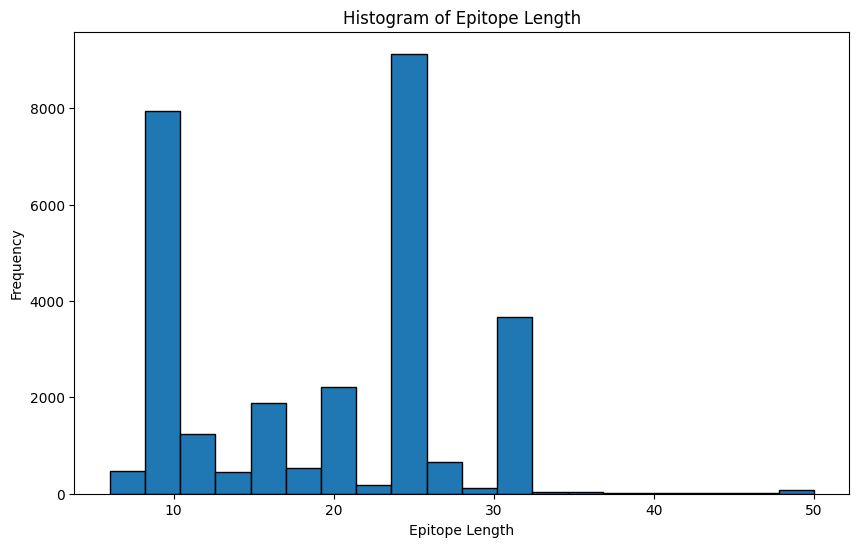

In [47]:
# hist of epitope length
plt.figure(figsize=(10, 6))
plt.hist(epitopes['epitope_length'], bins=20, edgecolor='black')
plt.xlabel('Epitope Length')
plt.ylabel('Frequency')
plt.title('Histogram of Epitope Length')
plt.show()

In [48]:
epitopes['epitope_length'].describe()

count    28681.000000
mean        19.389422
std          8.255925
min          6.000000
25%         10.000000
50%         20.000000
75%         25.000000
max         50.000000
Name: epitope_length, dtype: float64

#### Hydrophobicity

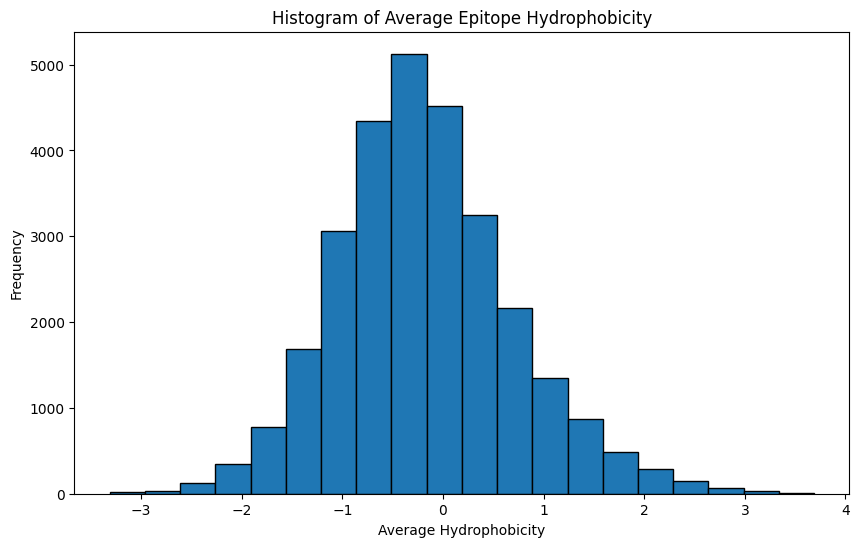

In [49]:
# histogram of average hydrophobicity
plt.figure(figsize=(10, 6))
plt.hist(epitopes['epitope_avg_hydro'], bins=20, edgecolor='black')
plt.xlabel('Average Hydrophobicity')
plt.ylabel('Frequency')
plt.title('Histogram of Average Epitope Hydrophobicity')
plt.show()

In [50]:
epitopes['epitope_avg_hydro'].describe()

count    28681.000000
mean        -0.178410
std          0.883064
min         -3.312000
25%         -0.762500
50%         -0.240000
75%          0.333333
max          3.688889
Name: epitope_avg_hydro, dtype: float64

#### Composition

In [51]:
# plot the composition of the epitopes, sort by the composition of the amino acids
# Calculate mean composition and sort

'''
mean_composition = epitope_composition_df.mean().sort_values(ascending=False)

# Plot the sorted composition
plt.figure(figsize=(10, 6))
plt.bar(mean_composition.index, mean_composition.values)
plt.xlabel('Amino Acid')
plt.ylabel('Composition')
plt.title('Composition of Epitopes')
plt.show()

'''

"\nmean_composition = epitope_composition_df.mean().sort_values(ascending=False)\n\n# Plot the sorted composition\nplt.figure(figsize=(10, 6))\nplt.bar(mean_composition.index, mean_composition.values)\nplt.xlabel('Amino Acid')\nplt.ylabel('Composition')\nplt.title('Composition of Epitopes')\nplt.show()\n\n"

#### n-gram frequency analysis

/var/folders/5j/4p7c5_1x2fg18bk0nf74_hg40000gn/T/ipykernel_26117/733366050.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ngram', y='count', data=top_ngram, palette="viridis")


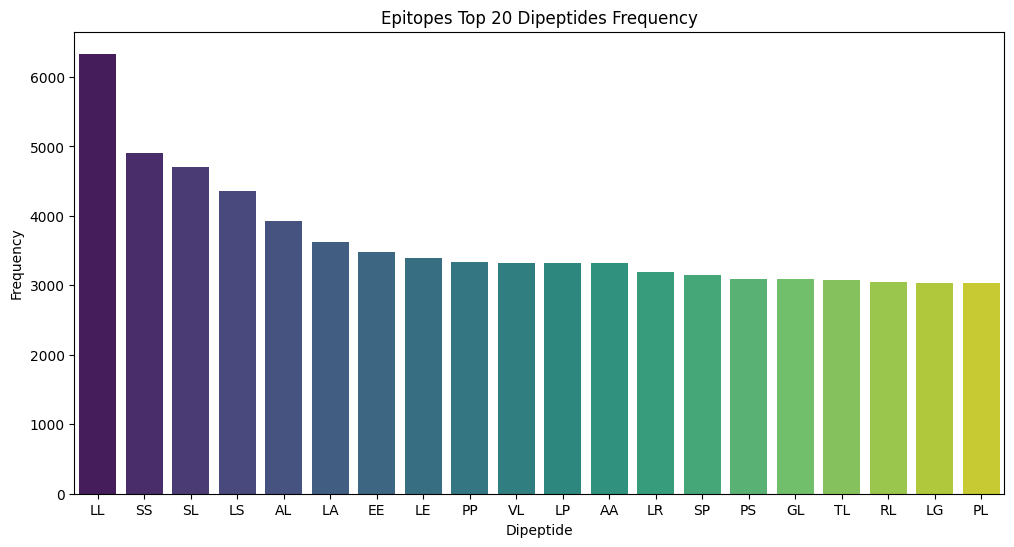

In [52]:
def ngram_frequency(peptides, n=2):
    ngrams = []
    for peptide in peptides:
        if len(peptide) < n:
            continue
        for i in range(len(peptide) - n + 1):
            ngram = peptide[i:i+n]
            ngrams.append(ngram)
    return Counter(ngrams)

dipeptide_freq = ngram_frequency(epitopes['epitope_name'], n=2)

df_ngram = pd.DataFrame(dipeptide_freq.items(), columns=['ngram', 'count'])
df_ngram = df_ngram.sort_values('count', ascending=False)

top_n = 20
top_ngram = df_ngram.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x='ngram', y='count', data=top_ngram, palette="viridis")
plt.title(f"Epitopes Top {top_n} Dipeptides Frequency")
plt.xlabel("Dipeptide")
plt.ylabel("Frequency")
plt.show()

#### MHC Binding Affinity

### Properties of negative samples

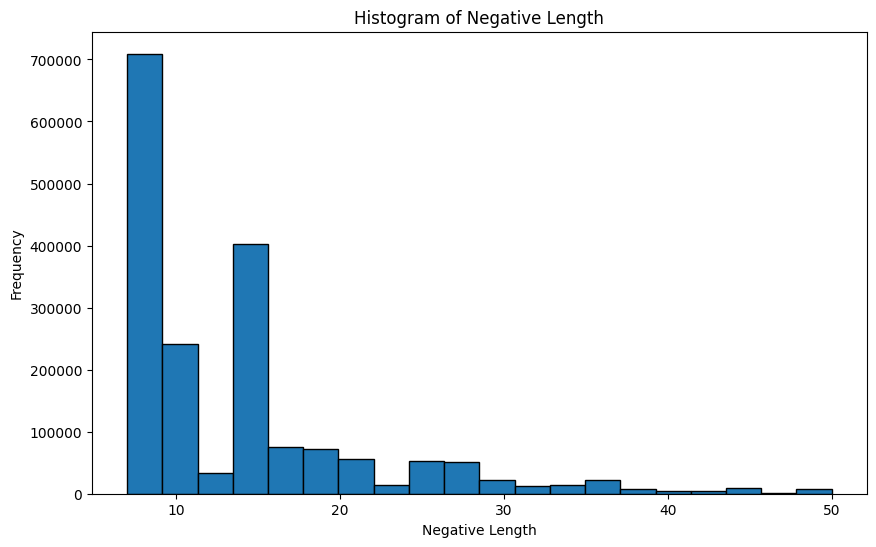

In [53]:
# hist of negative length
plt.figure(figsize=(10, 6))
plt.hist(negatives['peptide_length'], bins=20, edgecolor='black')
plt.xlabel('Negative Length')
plt.ylabel('Frequency')
plt.title('Histogram of Negative Length')
plt.show()

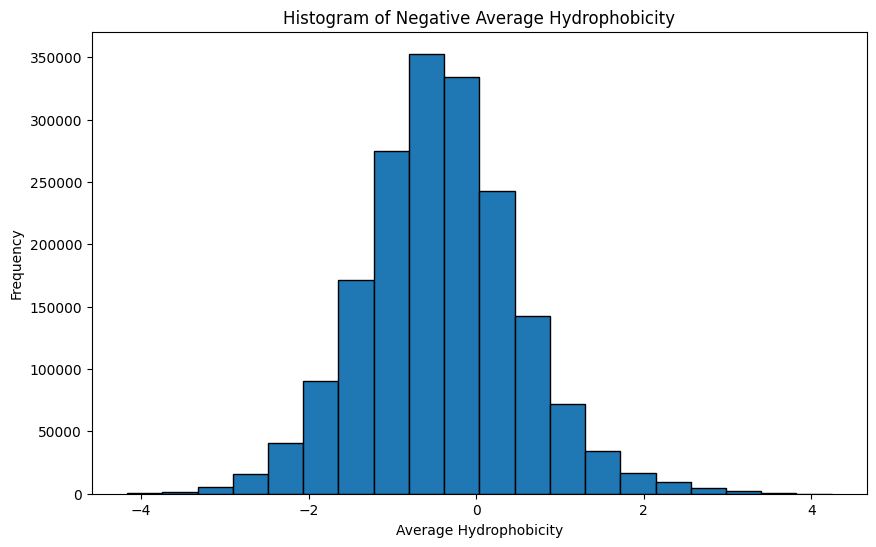

In [54]:
# histogram of average hydrophobicity
plt.figure(figsize=(10, 6))
plt.hist(negatives['peptide_avg_hydro'], bins=20, edgecolor='black')
plt.xlabel('Average Hydrophobicity')
plt.ylabel('Frequency')
plt.title('Histogram of Negative Average Hydrophobicity')
plt.show()

In [55]:
negatives['peptide_avg_hydro'].mean()

np.float64(-0.4169864724628861)

In [56]:
# plot the composition of the negatives, sort by the composition of the amino acids
# Calculate mean composition and sort

'''
mean_composition = negatives_composition_df.mean().sort_values(ascending=False)

# Plot the sorted composition
plt.figure(figsize=(10, 6))
plt.bar(mean_composition.index, mean_composition.values)
plt.xlabel('Amino Acid')
plt.ylabel('Composition')
plt.title('Composition of Negative Samples')
plt.show()
'''

"\nmean_composition = negatives_composition_df.mean().sort_values(ascending=False)\n\n# Plot the sorted composition\nplt.figure(figsize=(10, 6))\nplt.bar(mean_composition.index, mean_composition.values)\nplt.xlabel('Amino Acid')\nplt.ylabel('Composition')\nplt.title('Composition of Negative Samples')\nplt.show()\n"

## Modeling

### Data Preprocessing

In [57]:
epitopes = pd.read_csv("data/ninemer_epitopes.csv")
epitopes = epitopes.drop(columns=['fullsequence', 'mhcrestriction_name', 'mhcrestriction_class', 'epitope_length'])
epitopes = epitopes.rename(columns={'epitope_name': 'peptide', 'epitope_avg_hydro': 'peptide_avg_hydro'})
epitopes_BA_pred = pd.read_csv("data/ninemer_epitopes_BA_pred.csv")
epitopes_composition = epitopes.apply(lambda row: count_amino_acids(row['peptide']), axis=1).apply(pd.Series)

negatives = pd.read_csv("data/ninemer_negatives_trimmed.csv")
negatives = negatives.drop(columns=['mhc', 'peptide_length'])
negatives = negatives.rename(columns={'peptide': 'peptide'})
negatives = negatives.drop_duplicates(subset=['peptide'])
negatives_BA_pred = pd.read_csv("data/ninemer_negatives_trimmed_BA_pred.csv")
negatives_BA_pred = negatives_BA_pred.drop_duplicates(subset=['peptide'])
negatives_composition = negatives.apply(lambda row: count_amino_acids(row['peptide']), axis=1).apply(pd.Series)

In [58]:
# Merge the 'Score_BA' column from epitopes_BA_pred into the epitopes dataframe
epitopes = pd.merge(epitopes, epitopes_BA_pred[['peptide', 'Score_BA']], on='peptide', how='left')
#epitopes = pd.merge(epitopes, epitopes_composition, on='peptide', how='left')

negatives = pd.merge(negatives, negatives_BA_pred[['peptide', 'Score_BA']], on='peptide', how='left')
#negatives = pd.merge(negatives, negatives_composition, on='peptide', how='left')



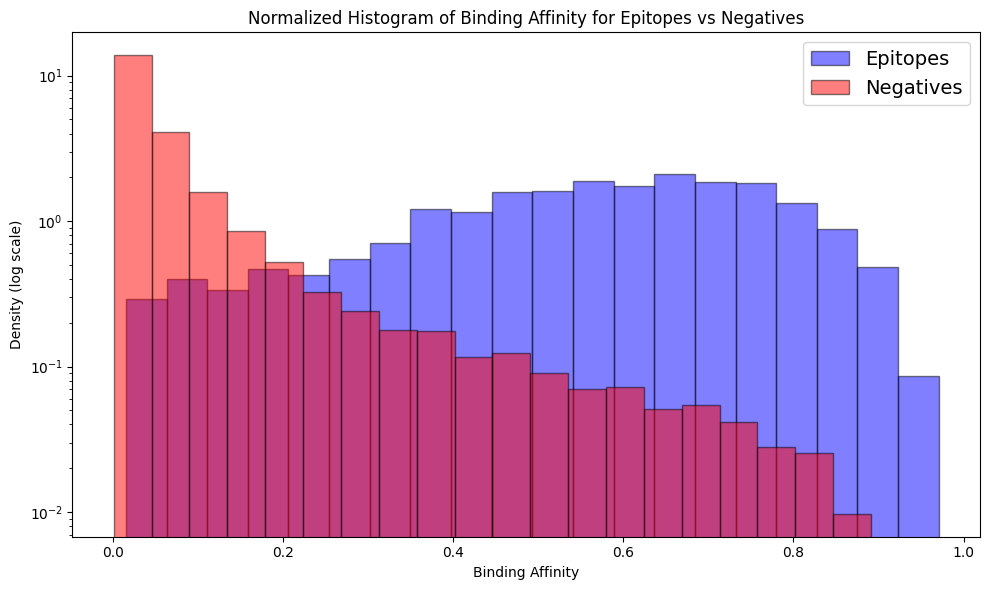

In [59]:
# plot Score_BA for epitopes and negatives overlaid on the same plot
plt.figure(figsize=(10, 6))

# Use density instead of raw counts to normalize the histograms
plt.hist(epitopes['Score_BA'], bins=20, alpha=0.5, color='blue', edgecolor='black', 
         label='Epitopes', density=True)
plt.hist(negatives['Score_BA'], bins=20, alpha=0.5, color='red', edgecolor='black', 
         label='Negatives', density=True)

# Alternative approach: use log scale for y-axis
plt.yscale('log')

plt.xlabel('Binding Affinity')
plt.ylabel('Density (log scale)')
plt.title('Normalized Histogram of Binding Affinity for Epitopes vs Negatives')
plt.legend(prop={'size': 14})  # Increased legend font size
plt.tight_layout()
plt.show()

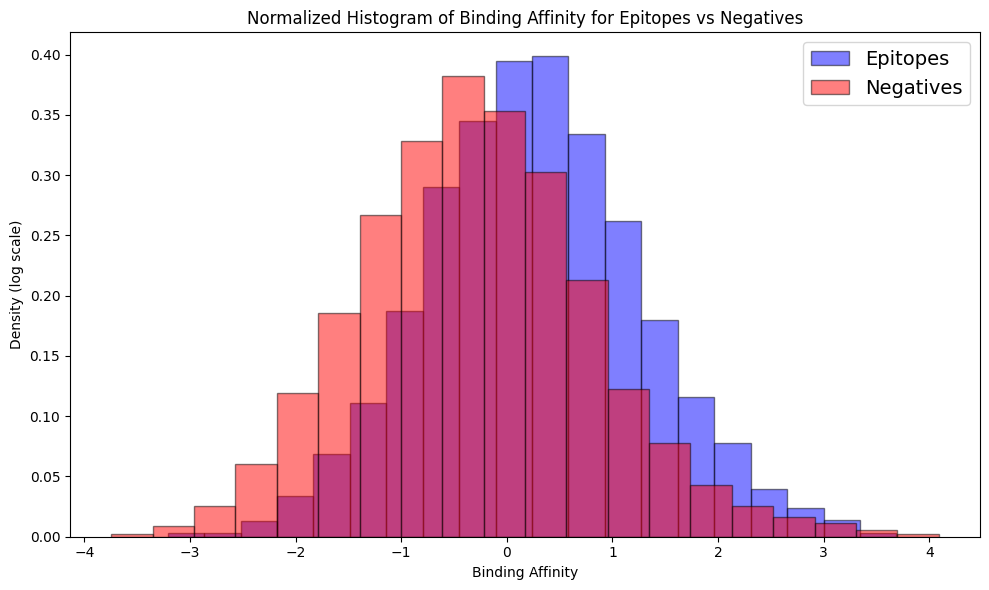

In [60]:
# plot Score_BA for epitopes and negatives overlaid on the same plot
plt.figure(figsize=(10, 6))

# Use density instead of raw counts to normalize the histograms
plt.hist(epitopes['peptide_avg_hydro'], bins=20, alpha=0.5, color='blue', edgecolor='black', 
         label='Epitopes', density=True)
plt.hist(negatives['peptide_avg_hydro'], bins=20, alpha=0.5, color='red', edgecolor='black', 
         label='Negatives', density=True)

# Alternative approach: use log scale for y-axis

plt.xlabel('Binding Affinity')
plt.ylabel('Density (log scale)')
plt.title('Normalized Histogram of Binding Affinity for Epitopes vs Negatives')
plt.legend(prop={'size': 14})  # Increased legend font size
plt.tight_layout()
plt.show()

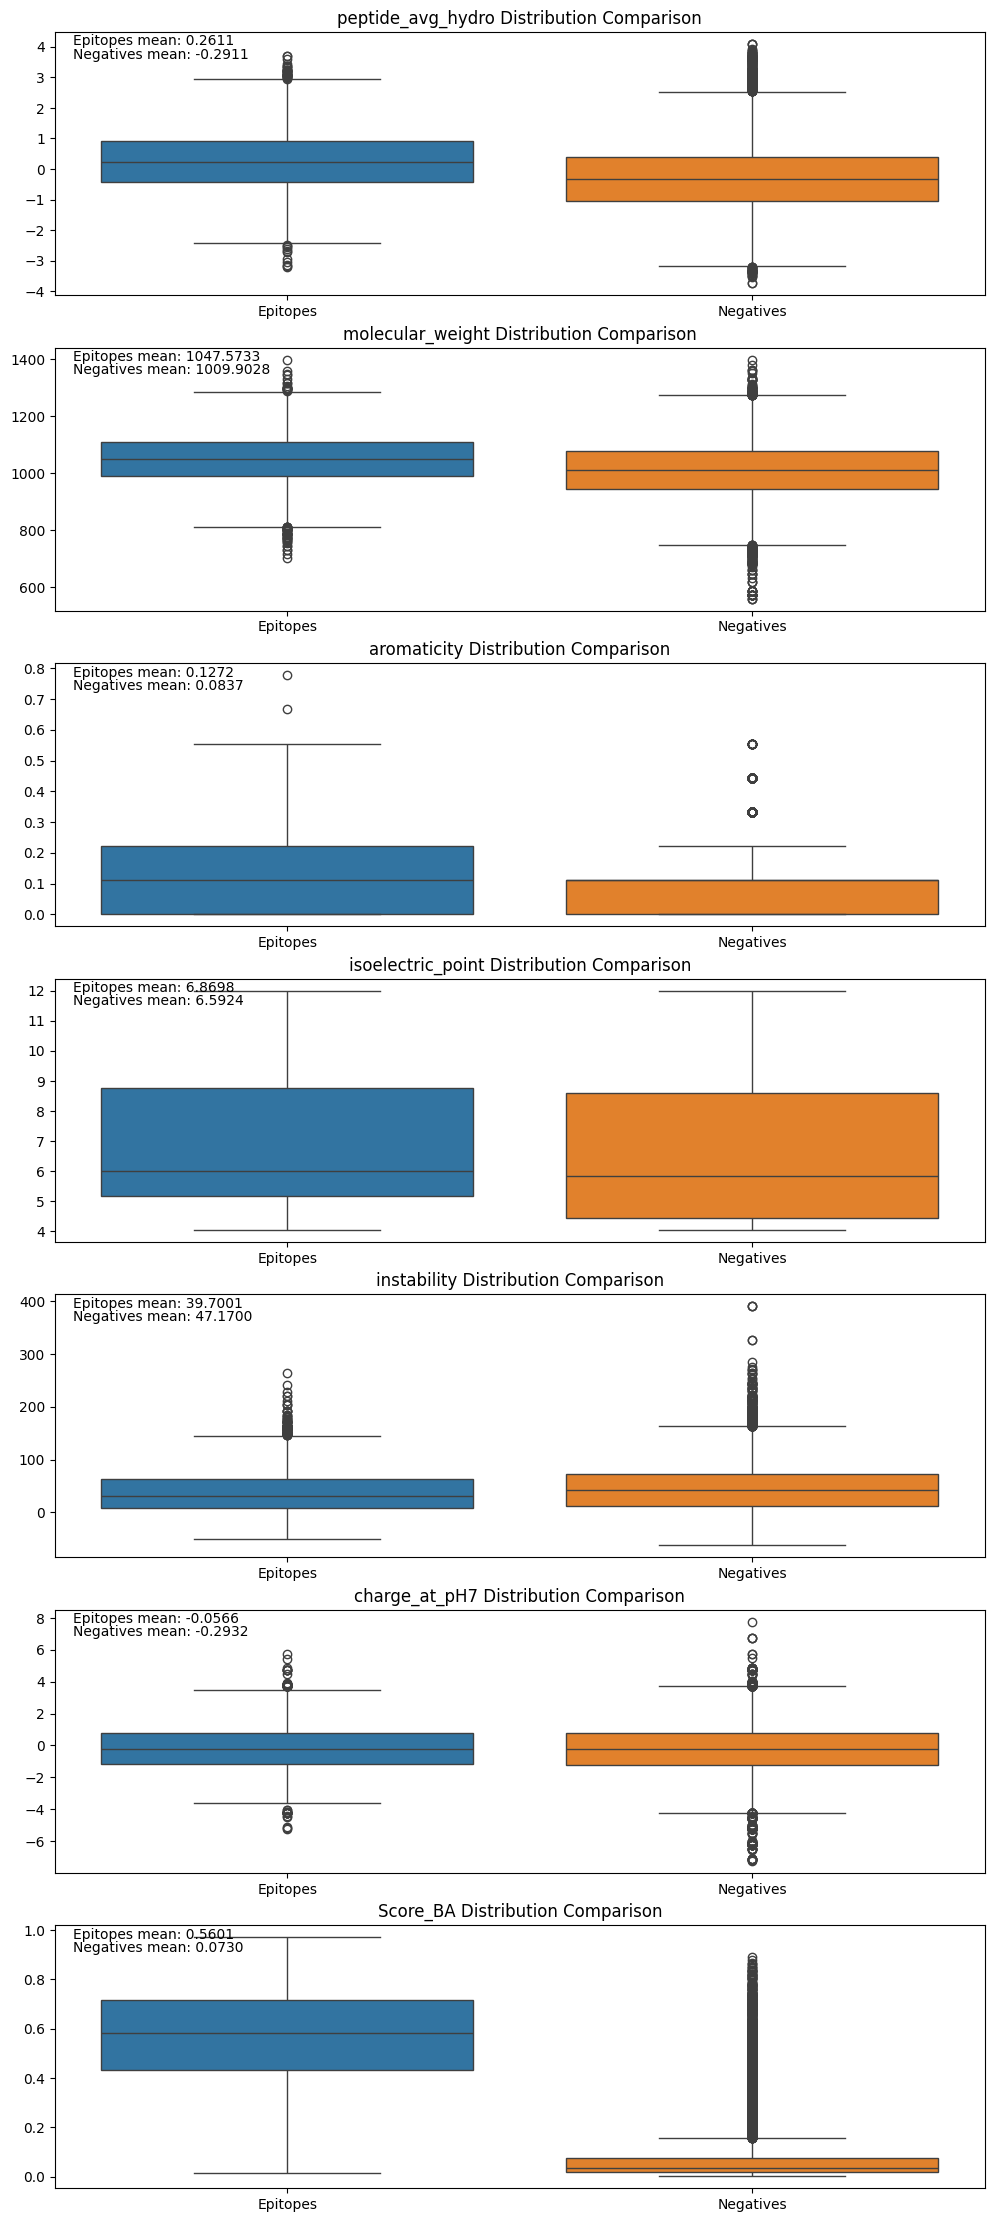

,Feature,Epitope Mean,Negative Mean,Mean % Diff,Epitope Std,Negative Std
0,peptide_avg_hydro,0.2611,-0.2911,-211.5120,1.0224,1.1101
1,molecular_weight,1047.5733,1009.9028,-3.5960,90.8725,98.5481
2,aromaticity,0.1272,0.0837,-34.1917,0.1159,0.0965
3,isoelectric_point,6.8698,6.5924,-4.0390,2.3995,2.3867
4,instability,39.7001,47.1700,18.8158,40.8781,44.8497
5,charge_at_pH7,-0.0566,-0.2932,418.1175,1.3494,1.4918
6,Score_BA,0.5601,0.0730,-86.9606,0.2028,0.1121


In [61]:
# Compare numeric features between epitopes and negatives datasets
numeric_features = ['peptide_avg_hydro', 'molecular_weight', 'aromaticity', 
                    'isoelectric_point', 'instability', 'charge_at_pH7', 'Score_BA']

# Create a figure with subplots for each numeric feature
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(12, 4*len(numeric_features)))
#fig.tight_layout(pad=5.0)

# Plot boxplots for each feature
for i, feature in enumerate(numeric_features):
    ax = axes[i]
    
    # Create a temporary dataframe for plotting
    plot_data = pd.DataFrame({
        'Epitopes': epitopes[feature],
        'Negatives': negatives[feature]
    })
    
    # Create boxplot
    sns.boxplot(data=plot_data, ax=ax)
    
    # Add feature statistics
    epitope_mean = epitopes[feature].mean()
    negative_mean = negatives[feature].mean()
    
    ax.set_title(f'{feature} Distribution Comparison')
    ax.text(0.02, 0.95, f'Epitopes mean: {epitope_mean:.4f}', transform=ax.transAxes)
    ax.text(0.02, 0.90, f'Negatives mean: {negative_mean:.4f}', transform=ax.transAxes)
    
    # Add p-value from t-test
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(
        epitopes[feature].dropna(), 
        negatives[feature].dropna(),
        equal_var=False  # Welch's t-test (doesn't assume equal variances)
    )
    #ax.text(0.02, 0.85, f'p-value: {p_value:.4e}', transform=ax.transAxes)

#plt.suptitle('Comparison of Numeric Features Between Epitopes and Negatives', fontsize=16)
plt.show()

# Create a summary table of the numeric features
summary_data = []
for feature in numeric_features:
    epitope_stats = epitopes[feature].describe()
    negative_stats = negatives[feature].describe()
    
    # Calculate percent difference between means
    mean_diff_pct = ((negative_stats['mean'] - epitope_stats['mean']) / 
                     epitope_stats['mean'] * 100)
    
    summary_data.append({
        'Feature': feature,
        'Epitope Mean': epitope_stats['mean'],
        'Negative Mean': negative_stats['mean'],
        'Mean % Diff': mean_diff_pct,
        'Epitope Std': epitope_stats['std'],
        'Negative Std': negative_stats['std'],
        'Epitope Min': epitope_stats['min'],
        'Negative Min': negative_stats['min'],
        'Epitope Max': epitope_stats['max'],
        'Negative Max': negative_stats['max']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)
display(summary_df[['Feature', 'Epitope Mean', 'Negative Mean', 'Mean % Diff', 
                    'Epitope Std', 'Negative Std']])


In [62]:
# Add label column to epitopes dataframe (positive class = 1)
epitopes['label'] = 1

# Add label column to negatives dataframe (negative class = 0)
negatives['label'] = 0

# Combine the positive and negative examples
combined_data = pd.concat([epitopes, negatives], ignore_index=True)

# Shuffle the combined dataset
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features and target
X = combined_data.drop(columns=['peptide', 'label'])
y = combined_data['label']

# Identify numerical columns to scale (exclude one-hot encoded amino acid columns)
numerical_cols = ['peptide_avg_hydro', 'molecular_weight', 'aromaticity', 'isoelectric_point', 'instability','Score_BA', 'charge_at_pH7']
#amino_acid_cols = [col for col in X.columns if col not in numerical_cols]

# Split the data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features using StandardScaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Print the shapes to verify the split
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Positive samples in training: {sum(y_train == 1)}")
print(f"Negative samples in training: {sum(y_train == 0)}")
print(f"Positive samples in testing: {sum(y_test == 1)}")
print(f"Negative samples in testing: {sum(y_test == 0)}")

Training set: 20502 samples
Testing set: 5126 samples
Positive samples in training: 4236
Negative samples in training: 16266
Positive samples in testing: 1059
Negative samples in testing: 4067


In [63]:
# drop the Score_BA column
#X_train = X_train.drop(columns=['Score_BA'])
#X_test = X_test.drop(columns=['Score_BA'])
# drop the ic50 column if it exists
#X_train = X_train.drop(columns=['ic50'])
#X_test = X_test.drop(columns=['ic50'])

Random Forest Model Evaluation:
Accuracy: 0.9126

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      4067
           1       0.82      0.74      0.78      1059

    accuracy                           0.91      5126
   macro avg       0.88      0.85      0.86      5126
weighted avg       0.91      0.91      0.91      5126



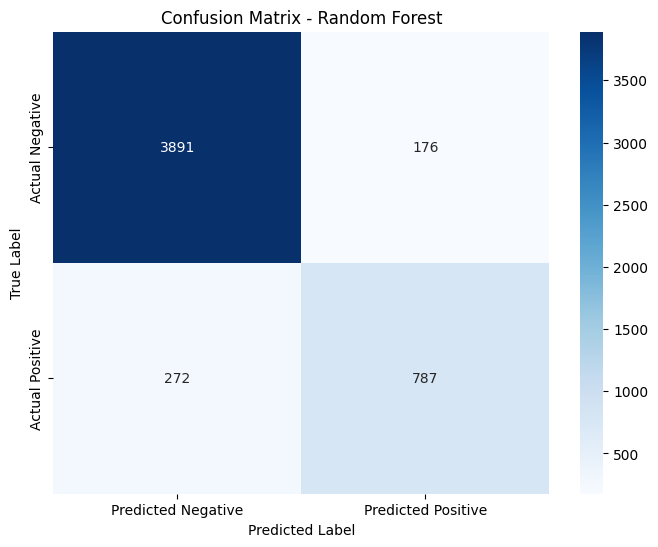


ROC AUC Score: 0.9511


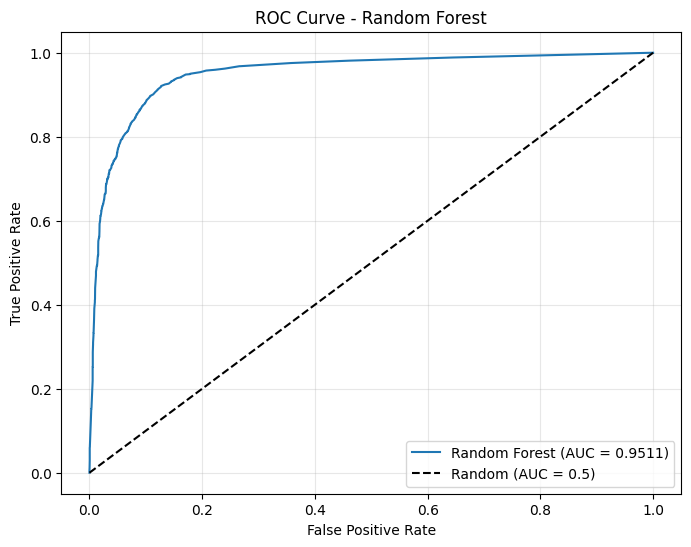

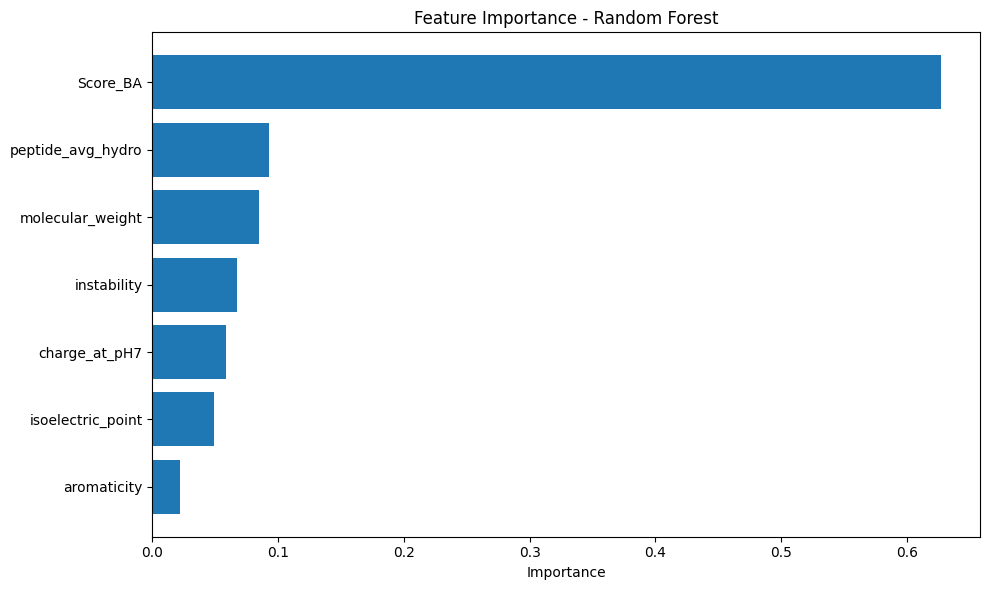

In [64]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,    # Maximum depth of trees
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for positive class

# Evaluate the model
print("Random Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

# Plot top 15 features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(np.arange(len(top_features)), top_features['Importance'], align='center')
plt.yticks(np.arange(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

### Clustering

Number of NaN values in dataset: 937


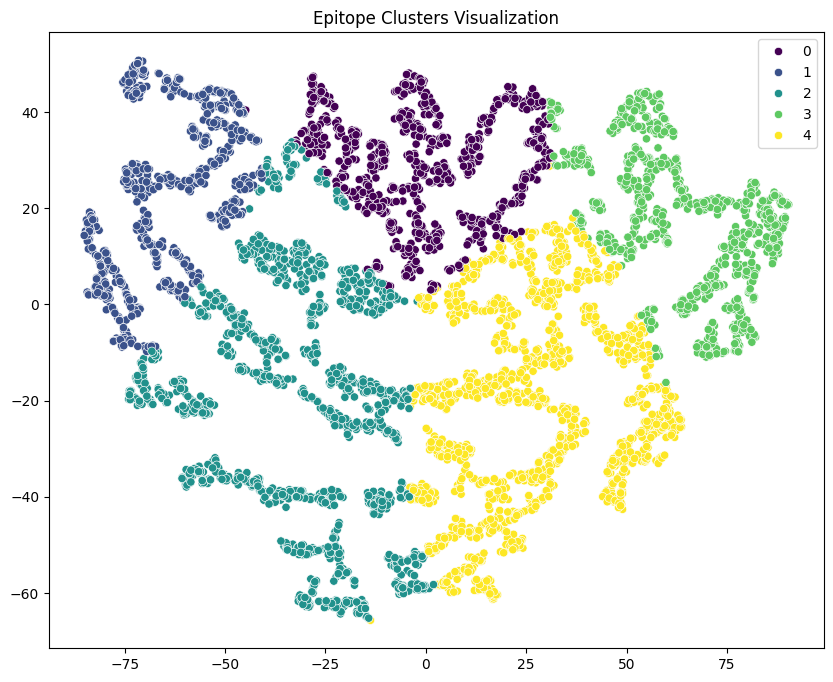

Cluster 0: 827 peptides
Average binding score: 0.55
Average hydrophobicity: 0.02
Top amino acids at each position:
Position_1: S(0.12), L(0.11), A(0.07)
Position_2: L(0.22), P(0.13), S(0.09)
Position_3: S(0.12), L(0.10), A(0.08)
Position_4: S(0.13), E(0.13), P(0.13)
Position_5: S(0.10), L(0.10), R(0.07)
Position_6: S(0.12), L(0.12), P(0.09)
Position_7: P(0.13), S(0.13), L(0.09)
Position_8: S(0.12), P(0.12), L(0.09)
Position_9: L(0.31), V(0.16), I(0.10)


Cluster 1: 732 peptides
Average binding score: 0.53
Average hydrophobicity: 0.75
Top amino acids at each position:
Position_1: A(0.20), G(0.14), S(0.14)
Position_2: L(0.31), A(0.13), P(0.13)
Position_3: A(0.16), G(0.11), S(0.11)
Position_4: G(0.17), P(0.16), A(0.15)
Position_5: G(0.19), A(0.16), V(0.11)
Position_6: G(0.16), S(0.14), L(0.12)
Position_7: A(0.13), P(0.12), S(0.11)
Position_8: A(0.18), S(0.16), G(0.12)
Position_9: L(0.29), V(0.25), A(0.14)


Cluster 2: 1419 peptides
Average binding score: 0.56
Average hydrophobicity: 0.57


In [65]:
# Example clustering approach
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Create feature matrix (using your existing features)
X = pd.concat([epitopes[['peptide_avg_hydro', 'molecular_weight', 'aromaticity', 
                         'isoelectric_point', 'instability', 'charge_at_pH7', 'Score_BA']], 
               # Add amino acid composition features
               pd.get_dummies(epitopes['peptide'].apply(lambda x: ''.join(x)), prefix='pos')], axis=1)

# Handle missing values
print("Number of NaN values in dataset:", X.isna().sum().sum())
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Option 1: K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust number of clusters
clusters = kmeans.fit_predict(X_imputed)
epitopes['cluster'] = clusters

# Option 2: Hierarchical clustering
# hclust = AgglomerativeClustering(n_clusters=5)
# clusters = hclust.fit_predict(X_imputed)

# Visualize with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_imputed)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters, palette='viridis')
plt.title('Epitope Clusters Visualization')
plt.show()

# Analyze cluster characteristics
for cluster_id in range(5):
    cluster_peptides = epitopes[epitopes['cluster'] == cluster_id]
    print(f"Cluster {cluster_id}: {len(cluster_peptides)} peptides")
    print(f"Average binding score: {cluster_peptides['Score_BA'].mean():.2f}")
    print(f"Average hydrophobicity: {cluster_peptides['peptide_avg_hydro'].mean():.2f}")
    
    # Find sequence motifs in cluster
    motif_analysis = pd.DataFrame()
    for i in range(9):  # For 9-mer peptides
        aa_counts = cluster_peptides['peptide'].str[i].value_counts(normalize=True)
        motif_analysis[f'Position_{i+1}'] = aa_counts
    print("Top amino acids at each position:")
    for col in motif_analysis.columns:
        top_aas = motif_analysis[col].nlargest(3)
        print(f"{col}: {', '.join([f'{aa}({freq:.2f})' for aa, freq in top_aas.items()])}")
    print("\n")

### New Model

## Convolutional Neural Network (CNN) Implementation

Below is a basic implementation of a Convolutional Neural Network using Keras (TensorFlow backend) for image classification. Adjust the `input_shape` and the number of output units in the final `Dense` layer according to your specific dataset.

## Preparing Data for CNN

We need to:
1. Filter the epitopes and negatives dataframes to only contain the sequences and labels
2. One-hot encode the amino acid sequences 
3. Split data into training and testing sets for the CNN model

In [66]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Step 1: Filter the epitopes and negatives dataframes to only contain sequences and labels
epitopes_filtered = epitopes[['peptide', 'label']].copy()
epitopes_filtered.rename(columns={'peptide': 'sequence'}, inplace=True)

negatives_filtered = negatives[['peptide', 'label']].copy()
negatives_filtered.rename(columns={'peptide': 'sequence'}, inplace=True)

# Combine the datasets
combined_data = pd.concat([epitopes_filtered, negatives_filtered], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Number of samples: {combined_data.shape[0]}")
print(f"Positive samples: {sum(combined_data['label'] == 1)}")
print(f"Negative samples: {sum(combined_data['label'] == 0)}")

# Step 2: Prepare for one-hot encoding
# First, get all unique amino acids in our dataset
all_sequences = combined_data['sequence'].values
unique_chars = sorted(set(''.join(all_sequences)))
print(f"Unique amino acids in dataset: {unique_chars}")

# Create mapping dictionaries for one-hot encoding
char_to_index = {char: i+1 for i, char in enumerate(unique_chars)}  # Start from 1, reserve 0 for padding
index_to_char = {i+1: char for i, char in enumerate(unique_chars)}
index_to_char[0] = ''  # Padding token

# Find maximum sequence length
max_length = max(len(seq) for seq in all_sequences)
print(f"Maximum sequence length: {max_length}")

# Convert sequences to integer sequences
int_sequences = []
for seq in all_sequences:
    int_seq = [char_to_index[char] for char in seq]
    int_sequences.append(int_seq)

# Pad sequences to have the same length
padded_sequences = pad_sequences(int_sequences, maxlen=max_length, padding='post')

# One-hot encode the padded sequences
num_chars = len(unique_chars) + 1  # +1 for padding token
X_onehot = np.zeros((len(padded_sequences), max_length, num_chars))

for i, seq in enumerate(padded_sequences):
    for j, char_idx in enumerate(seq):
        X_onehot[i, j, char_idx] = 1.0  # One-hot encode

# Get labels
y = combined_data['label'].values

# Print shapes to verify dimensions
print(f"X_onehot shape: {X_onehot.shape}")
print(f"Number of unique amino acids (including padding): {num_chars}")

# Step 3: Split data into training, validation, and testing sets (70/15/15 split)
# First split into temporary train and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_onehot, y, test_size=0.15, random_state=42, stratify=y
)

# Then split the temporary train into final train and validation
# To get 70/15 split from the original data, we need to calculate the right proportion:
# If test is 15% of total, then validation should be 15/85 of the remaining data (approx 17.65%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print(f"Training set shape: {X_train.shape} ({X_train.shape[0]/X_onehot.shape[0]:.1%} of total)")
print(f"Validation set shape: {X_val.shape} ({X_val.shape[0]/X_onehot.shape[0]:.1%} of total)")
print(f"Testing set shape: {X_test.shape} ({X_test.shape[0]/X_onehot.shape[0]:.1%} of total)")

print(f"Positive samples in training: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train):.1%})")
print(f"Negative samples in training: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train):.1%})")

print(f"Positive samples in validation: {sum(y_val == 1)} ({sum(y_val == 1)/len(y_val):.1%})")
print(f"Negative samples in validation: {sum(y_val == 0)} ({sum(y_val == 0)/len(y_val):.1%})")

print(f"Positive samples in testing: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test):.1%})")
print(f"Negative samples in testing: {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test):.1%})")

Number of samples: 25628
Positive samples: 5295
Negative samples: 20333
Unique amino acids in dataset: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Maximum sequence length: 9
X_onehot shape: (25628, 9, 21)
Number of unique amino acids (including padding): 21
Training set shape: (17938, 9, 21) (70.0% of total)
Validation set shape: (3845, 9, 21) (15.0% of total)
Testing set shape: (3845, 9, 21) (15.0% of total)
Positive samples in training: 3707 (20.7%)
Negative samples in training: 14231 (79.3%)
Positive samples in validation: 794 (20.7%)
Negative samples in validation: 3051 (79.3%)
Positive samples in testing: 794 (20.7%)
Negative samples in testing: 3051 (79.3%)


## Convolutional Neural Network (CNN) Implementation

Below is a basic implementation of a Convolutional Neural Network using Keras (TensorFlow backend) for sequence classification.

Class weights: {0: np.float64(0.6302438338837748), 1: np.float64(2.419476665767467)}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 9, 32)          │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 9, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,290 (360.51 KB)

 Trainable params: 91,458 (357.26 KB)

 Non-trainable params: 832 (3.25 KB)

None
Epoch 1/20
559/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5567 - loss: 1.3226
Epoch 1: val_accuracy improved from -inf to 0.65878, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5569 - loss: 1.3219 - val_accuracy: 0.6588 - val_loss: 1.0086 - learning_rate: 0.0010
Epoch 2/20
556/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6864 - loss: 0.9309
Epoch 2: val_accuracy improved from 0.65878 to 0.72510, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6866 - loss: 0.9306 - val_accuracy: 0.7251 - val_loss: 0.8847 - learning_rate: 0.0010
Epoch 3/20
556/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7547 - loss: 0.7967
Epoch 3: val_accuracy improved from 0.72510 to 0.74668, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7547 - loss: 0.7967 - val_accuracy: 0.7467 - val_loss: 0.7680 - learning_rate: 0.0010
Epoch 4/20
535/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7679 - loss: 0.7197
Epoch 4: val_accuracy improved from 0.74668 to 0.75527, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7678 - loss: 0.7195 - val_accuracy: 0.7553 - val_loss: 0.7225 - learning_rate: 0.0010
Epoch 5/20
538/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7898 - loss: 0.6385
Epoch 5: val_accuracy improved from 0.75527 to 0.75553, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7897 - loss: 0.6385 - val_accuracy: 0.7555 - val_loss: 0.6762 - learning_rate: 0.0010
Epoch 6/20
547/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - loss: 0.5838
Epoch 6: val_accuracy did not improve from 0.75553
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7979 - loss: 0.5841 - val_accuracy: 0.7376 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 7/20
539/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8053 - loss: 0.5432
Epoch 7: val_accuracy improved from 0.75553 to 0.76411, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8051 - loss: 0.5434 - val_accuracy: 0.7641 - val_loss: 0.6160 - learning_rate: 0.0010
Epoch 8/20
546/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8141 - loss: 0.5130
Epoch 8: val_accuracy improved from 0.76411 to 0.76749, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8139 - loss: 0.5132 - val_accuracy: 0.7675 - val_loss: 0.6280 - learning_rate: 0.0010
Epoch 9/20
553/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8248 - loss: 0.4925
Epoch 9: val_accuracy improved from 0.76749 to 0.77217, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8247 - loss: 0.4926 - val_accuracy: 0.7722 - val_loss: 0.5799 - learning_rate: 0.0010
Epoch 10/20
552/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8243 - loss: 0.4811
Epoch 10: val_accuracy improved from 0.77217 to 0.78778, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8242 - loss: 0.4811 - val_accuracy: 0.7878 - val_loss: 0.5639 - learning_rate: 0.0010
Epoch 11/20
552/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8337 - loss: 0.4607
Epoch 11: val_accuracy did not improve from 0.78778
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8336 - loss: 0.4608 - val_accuracy: 0.7854 - val_loss: 0.5924 - learning_rate: 0.0010
Epoch 12/20
555/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8493 - loss: 0.4375
Epoch 12: val_accuracy did not improve from 0.78778
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8491 - loss: 0.4378 - val_accuracy: 0.7625 - val_loss: 0.6101 - learning_rate: 0.0010
Epoch 13/20
543/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8482 - loss: 0.4345
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 13: val_accuracy did not improve from 0.78778
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8480 - loss: 0.4350 - val_

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8641 - loss: 0.3948 - val_accuracy: 0.7940 - val_loss: 0.6105 - learning_rate: 2.0000e-04
Epoch 15/20
559/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9026 - loss: 0.3329
Epoch 15: val_accuracy improved from 0.79402 to 0.79662, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9026 - loss: 0.3329 - val_accuracy: 0.7966 - val_loss: 0.6307 - learning_rate: 2.0000e-04
Epoch 16/20
547/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9141 - loss: 0.3058
Epoch 16: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 16: val_accuracy improved from 0.79662 to 0.80754, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9141 - loss: 0.3058 - val_accuracy: 0.8075 - val_loss: 0.6478 - learning_rate: 2.0000e-04
Epoch 17/20
547/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9288 - loss: 0.2707
Epoch 17: val_accuracy did not improve from 0.80754
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9288 - loss: 0.2708 - val_accuracy: 0.8047 - val_loss: 0.6830 - learning_rate: 4.0000e-05
Epoch 18/20
553/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9371 - loss: 0.2622
Epoch 18: val_accuracy improved from 0.80754 to 0.81040, saving model to best_optimized_cnn_model.h5


561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9370 - loss: 0.2622 - val_accuracy: 0.8104 - val_loss: 0.7029 - learning_rate: 4.0000e-05
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 10.
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.8062 - loss: 0.5543
Test accuracy: 0.8044
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Threshold: 0.10, F1 Score: 0.5479
Threshold: 0.15, F1 Score: 0.5692
Threshold: 0.20, F1 Score: 0.5836
Threshold: 0.25, F1 Score: 0.5906
Threshold: 0.30, F1 Score: 0.5972
Threshold: 0.35, F1 Score: 0.6058
Threshold: 0.40, F1 Score: 0.6033
Threshold: 0.45, F1 Score: 0.6078
Threshold: 0.50, F1 Score: 0.6136
Threshold: 0.55, F1 Score: 0.6144
Threshold: 0.60, F1 Score: 0.6049
Threshold: 0.65, F1 Score: 0.6001
Threshold: 0.70, F1 Score: 0.5714
Threshold: 0.75, F1 Score: 0.5418
Threshold: 0.80, F1 Score: 0.5015
Threshold: 0.85, F1 Score: 0.4382

Optimal threshold: 0.55 with F1 Score: 0.6144

Classification Report with Optimized

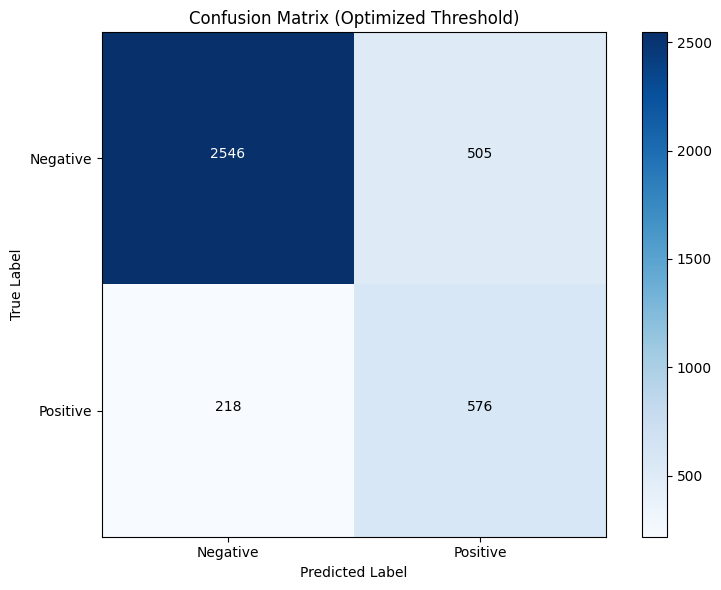

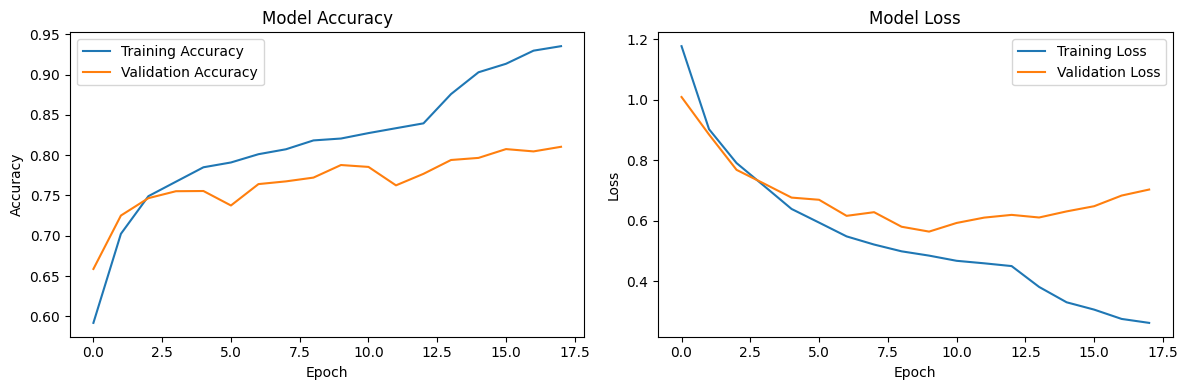

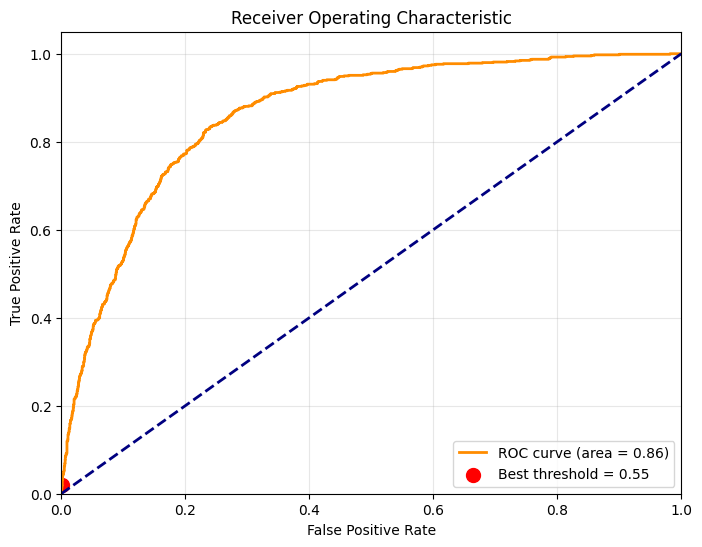

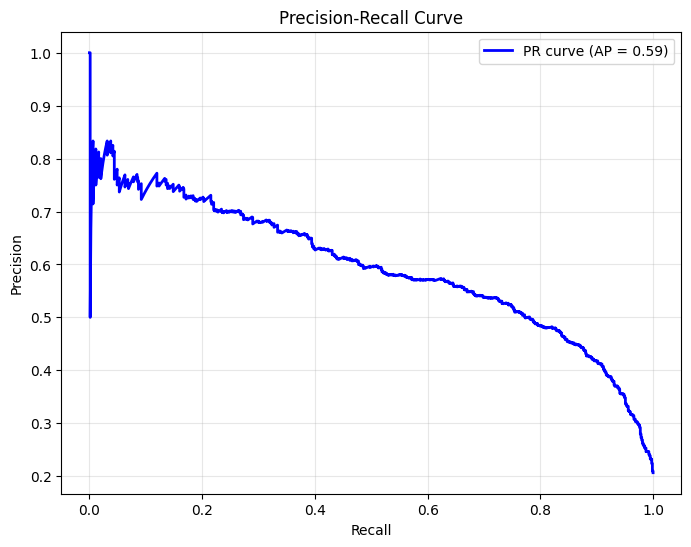

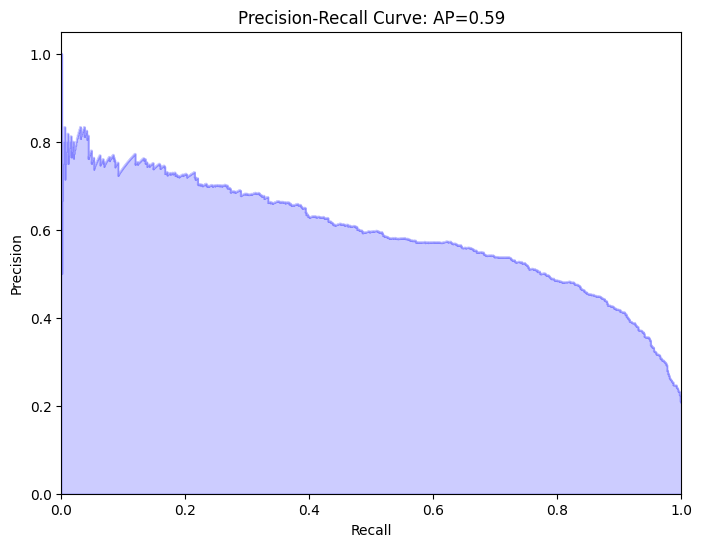

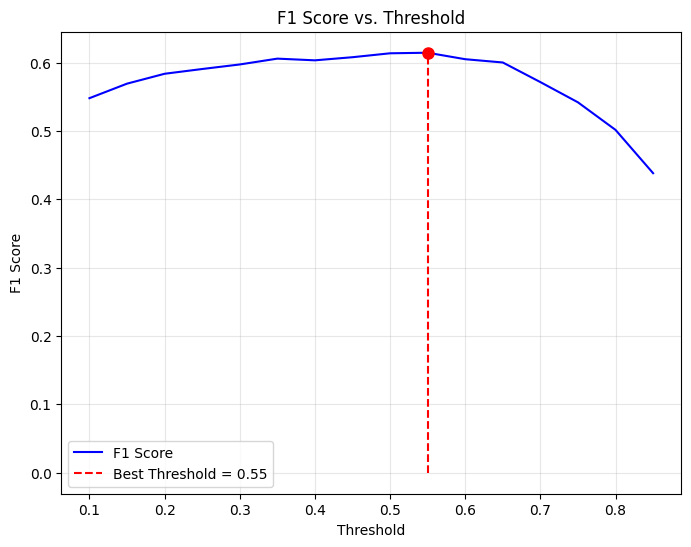


Model performance comparison:
Optimal threshold: 0.55
Original model test accuracy: 0.8044
Optimized model test accuracy (with best threshold): 0.8120
Optimized model F1 score: 0.6144


In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Define the focal loss function to better handle class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        # Convert one-hot encoded targets to integers
        if y_true.shape[-1] == 1:
            y_true = tf.squeeze(y_true, axis=-1)
        y_true = tf.cast(y_true, tf.int32)
        
        # Get the standard sparse categorical crossentropy
        sce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
        
        # Calculate the prediction probability for the true class
        y_pred_proba = tf.gather_nd(y_pred, tf.stack([tf.range(tf.shape(y_true)[0]), tf.cast(y_true, tf.int32)], axis=1))
        
        # Apply focal loss formula
        # p_t = p if y == 1 else 1-p for class 0
        p_t = y_pred_proba
        # Add the alpha weighing factor
        alpha_factor = 1.0
        if alpha is not None:
            # alpha_t = alpha if y == 1 else 1-alpha for class 0
            alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1-alpha)
            alpha_factor = alpha_t
        
        # Calculate focal weight
        gamma_factor = tf.pow(1.0 - p_t, gamma)
        
        # Calculate the final loss
        focal_loss = alpha_factor * gamma_factor * sce
        
        return tf.reduce_mean(focal_loss)
    
    return focal_loss_fn

# Create an optimized CNN model for sequence data
def create_optimized_cnn_model(input_shape, num_classes=2, use_focal_loss=True):
    inputs = Input(shape=input_shape)
    
    # First convolutional block
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    
    # Second convolutional block with increased filters
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    
    # Third convolutional block with even more filters
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    
    # Flatten and dense layers
    x = Flatten()(x)
    
    # Add more capacity to the dense layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Use a lower learning rate for better stability
    optimizer = Adam(learning_rate=0.001)
    
    # Use focal loss if requested, otherwise use standard cross-entropy
    if use_focal_loss:
        loss = focal_loss(gamma=2.0, alpha=0.75)  # Adjust alpha based on class imbalance
    else:
        loss = 'sparse_categorical_crossentropy'
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

# Calculate class weights based on class frequencies
# This gives more weight to the minority class during training
def compute_class_weights(y_train):
    # Count the number of samples per class
    class_counts = np.bincount(y_train)
    # Calculate the weight for each class (inversely proportional to class frequency)
    total_samples = len(y_train)
    class_weights = {
        i: total_samples / (len(class_counts) * count) 
        for i, count in enumerate(class_counts)
    }
    return class_weights

# Get the class weights for our training data
class_weights = compute_class_weights(y_train)
print(f"Class weights: {class_weights}")

# Create an optimized CNN model
optimized_cnn_model = create_optimized_cnn_model(input_shape=(X_train.shape[1], X_train.shape[2]), use_focal_loss=False)
print(optimized_cnn_model.summary())

# Define more sophisticated callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_optimized_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model with class weights
history = optimized_cnn_model.fit(
    X_train, y_train,
    epochs=20,  # Increase epochs since we have early stopping
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weights  # Use class weights during training
)

# Evaluate the model on test data
test_loss, test_accuracy = optimized_cnn_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions on test data
y_pred_proba = optimized_cnn_model.predict(X_test)
y_pred_proba_positive = y_pred_proba[:, 1]  # Probability for positive class

# Find the optimal threshold for F1 score
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_thresholded = (y_pred_proba_positive >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresholded)
    f1_scores.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Get the best threshold
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]
print(f"\nOptimal threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")

# Apply the best threshold
y_pred = (y_pred_proba_positive >= best_threshold).astype(int)

# Print classification report with the optimized threshold
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report with Optimized Threshold:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Optimized Threshold)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_positive)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[np.argmin(np.abs(thresholds - best_threshold))], 
            tpr[np.argmin(np.abs(thresholds - best_threshold))], 
            c='red', marker='o', s=100, label=f'Best threshold = {best_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Plot Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_positive)
avg_precision = average_precision_score(y_test, y_pred_proba_positive)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.show()

# Compare with the best threshold ROC point
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='blue', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='blue', step='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(avg_precision))
plt.show()

# Plot F1 Score vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, 'b-', label='F1 Score')
plt.plot([best_threshold, best_threshold], [0, best_f1], 'r--', label=f'Best Threshold = {best_threshold:.2f}')
plt.plot(best_threshold, best_f1, 'ro', markersize=8)
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Comparing model performance before and after optimization
print(f"\nModel performance comparison:")
print(f"Optimal threshold: {best_threshold:.2f}")
print(f"Original model test accuracy: {test_accuracy:.4f}")
print(f"Optimized model test accuracy (with best threshold): {accuracy_score(y_test, y_pred):.4f}")
print(f"Optimized model F1 score: {f1_score(y_test, y_pred):.4f}")

In [68]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]
